# File Information

Name: Amie Davis

Course: DSC680 - Data Science

Assignment: Project3 - Malicious Traffic Detector

Purpose: Build Logistic Regression model

Usage: Python 3.7.6

   Developed using Jupter Notebook 6.0.3

# Data Source
DarkNet 2020 dataset from the Canadian Institute for Cybersecurity at the University of New Brunswick

## Import required packages

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data Preparation

## Load Data

In [2]:
# Load data into dataframe
data_file = "Data\cleaned_data.csv"
df = pd.read_csv(data_file)

## Standardization

In [3]:
# Although standardization is not needed for Logistic Regression, 
# it is recommended when using weights to counter imbalanced classes

# Original df
#print(df.head())

# Separate features from target
features = df.drop(['tor_indicator'], axis=1)

# Convert df to numpy array
x = features.values

# Create function to standardize feature data
# Accepts array object and returns scaled array
def scale_data(x):
    
    # Create scaler
    scaler = preprocessing.StandardScaler()

    # Transform the feature
    x_scaled = scaler.fit_transform(x)
    
    # Convert back to Pandas dataframe
    std_df = pd.DataFrame(x_scaled, columns = 
                      ['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
                       'Total Bwd packets', 'Flow Packets', 'Flow IAT Mean', 'Flow IAT Std',
                       'Flow IAT Min', 'Fwd IAT Std', 'Bwd IAT Std', 'Fwd Packets',
                       'Down/Up Ratio', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
                       'Idle Mean', 'Idle Std', 'src_ip_class_a', 'src_ip_class_b',
                       'src_ip_class_c', 'src_ip_host', 'dst_ip_class_a', 'dst_ip_class_b',
                       'dst_ip_class_c', 'dst_ip_host', 'Audio-Streaming', 'Browsing', 'Chat',
                       'Email', 'File-Transfer', 'P2P', 'VOIP', 'Video-Streaming'])

    # Print Standardized df
    #print(std_df.head())

    return std_df

# Scale data before training
# Pass features as numpy array
std_df = scale_data(x)

## Split Dataset

In [4]:
# Split data into two sets: Training and Validation.

# Create features dataset
data_model_X = std_df

# Create target dataset
# Replace category name
data_model_y = df.replace({'tor_indicator': {1: 'Tor', 0: 'Non-Tor'}})['tor_indicator']

# Split the data into training and validation datasets
# Save 30% for validation
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, test_size =0.3, random_state=11)

# Check details of the datasets
print("Number of samples in original set: ", data_model_X.shape[0])
print("Number of samples in training set: ", X_train.shape[0])
print("Number of samples in validation set: ", X_val.shape[0])

# Check distribution of each set
# Tor and Non-Tor
print('\n')
print('Number of Tor and Non-Tor in the original set:')
print(data_model_y.value_counts())

print('\n')
print('Number of Tor and Non-Tor in the training set:')
print(y_train.value_counts())

print('\n')
print('Number of Tor and Non-Tor in the validation set:')
print(y_val.value_counts())


Number of samples in original set:  94748
Number of samples in training set:  66323
Number of samples in validation set:  28425


Number of Tor and Non-Tor in the original set:
Non-Tor    93356
Tor         1392
Name: tor_indicator, dtype: int64


Number of Tor and Non-Tor in the training set:
Non-Tor    65346
Tor          977
Name: tor_indicator, dtype: int64


Number of Tor and Non-Tor in the validation set:
Non-Tor    28010
Tor          415
Name: tor_indicator, dtype: int64


# Model Evaluation and Selection

## Import required packages

In [5]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import matthews_corrcoef

## Build Model

In [6]:
# Run a Logistic Regression Model to predict if traffic is Tor or not

# Instantiate the classification model 
# class_weight parameter set to balanced
# "The balanced mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data."
logistic_regression = LogisticRegression(class_weight = 'balanced', random_state=0, solver='sag')

# Fit model to training data
model = logistic_regression.fit(X_train, y_train)

### Analysis

Due to bug with lbfgs solver code (corrected in Scikit-Learn 0.24 which is not yet compatible with Yellowbrick), changed deafult solver.  Built models with multiple solvers to select best solver for this use case (sag).  See more details under model evaluation section below.

## Model Evaluation

### Confusion Matrix

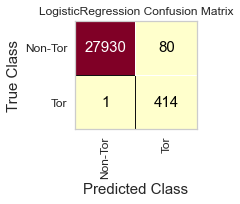

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [7]:
# Use Confusion Matrix to evaluate the model 

# The ConfusionMatrix visualizer is a ScoreVisualizer that takes a scikit-learn classifier 
# and a set of test X and y values and returns a report showing how each of the test values predicted 
# classes compare to their actual classes.

# Set up the figure size
plt.rcParams['figure.figsize'] = (3, 3)

classes = ['Non-Tor','Tor']
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit the passed model
cm.fit(X_train, y_train)
  
# Score runs predict() and creates the confusion_matrix
cm.score(X_val, y_val)
       
# Change font for labels
for label in cm.ax.texts:
    label.set_size(15)

# Set label fonts
plt.xlabel('False Class',fontsize=15)
plt.ylabel('Predicted Class',fontsize=15)
    
# Draw plot
cm.poof()

#### Analysis

Accuracy = (True Positives + True Negatives)/All

Note that accuracy is not the best measure since the target class is imbalanced.  Using this confusion matrix, accuracy is calculated to be 99.7%.

False negative results of solver comparison.  Avoid over-fitting by using sag or saga.
- lbfgs 0 false negatives
- liblinear 0 false negatives
- newton-cg 0 false negatives
- sag 1 false negative 
- saga 1 false negative

### Classification Report

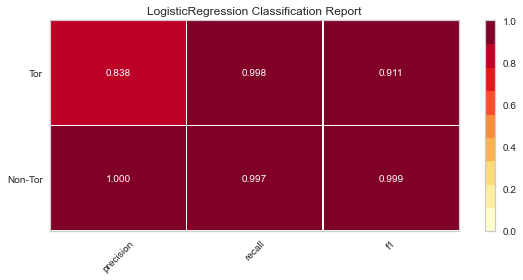

In [8]:
# Use Precision, Recall & F1 score to evaluate the model
# Create a Report of Evaluation Metrics

# Set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = 10

# Instantiate the ClassificationReport visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data

g = visualizer.poof()

#### Analysis
The darker, the better.  Predictions for both Tor and Non-Tor traffic were good for all metrics, although precision showed a slightly lower result for records identified as Tor.

In [9]:
# Use Matthews Correlation Coefficient (MCC) for a better metric for imbalanced classes
from sklearn.metrics import matthews_corrcoef

y_pred = model.predict(X_val)
y_true = y_val

matthews_corrcoef(y_true, y_pred)

0.9130213905960409

### Analysis

MCC results of solver comparison.  Best MCC is with newton-cg at 95%.  However, to avoid overfitting, will select sag with an MCC of 91%.
- lbfgs MCC = 91%
- liblinear MCC = 94%, 0 false negatives
- newton-cg MCC = 95%, 0 false negatives
- sag MCC = 91%, 1 false negative 
- saga MCC = 89%, 1 false negative

## Feature Importance

Feature: 0, Score: -1.84154
Feature: 1, Score: -5.24849
Feature: 2, Score: -0.12271
Feature: 3, Score: -0.28979
Feature: 4, Score: 0.07927
Feature: 5, Score: 0.01286
Feature: 6, Score: -0.61381
Feature: 7, Score: 0.95608
Feature: 8, Score: 0.23443
Feature: 9, Score: -0.41324
Feature: 10, Score: -0.42101
Feature: 11, Score: 0.04593
Feature: 12, Score: -0.29026
Feature: 13, Score: 0.04705
Feature: 14, Score: 1.57613
Feature: 15, Score: 1.14001
Feature: 16, Score: -0.43778
Feature: 17, Score: -0.24838
Feature: 18, Score: 1.30902
Feature: 19, Score: -0.40499
Feature: 20, Score: -0.18590
Feature: 21, Score: 1.33590
Feature: 22, Score: 0.55273
Feature: 23, Score: -0.46296
Feature: 24, Score: -0.31142
Feature: 25, Score: 0.31601
Feature: 26, Score: 0.25084
Feature: 27, Score: 0.15919
Feature: 28, Score: 0.28810
Feature: 29, Score: 0.00660
Feature: 30, Score: -0.26308
Feature: 31, Score: -0.60768
Feature: 32, Score: 2.23351
Feature: 33, Score: 0.61225


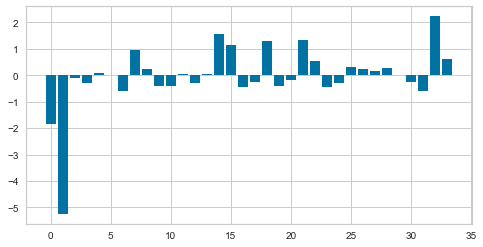

In [10]:
# Use scaled data and review the model coefficients to approximate feature importance

# Get model coefficients
importance = model.coef_[0]

# Summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Analysis
Features with positive scores predicts class 1 (Tor), whereas features with negative scores predict class 0 (Non-Tor).  

The feature that has the most impact on the model is Feature 1, the Destination Port, followed by Feature 32, the VOIP indicator.

# Conclusion

After reviewing multiple metrics, I believe that Matthews Correlation Coefficient is the best metric for this case.  Accuracy is not recommended for logistic regression.  The imbalanced class of 2% Tor traffic versus 98% Non-Tor traffic can elevate other metrics, such as F1, precision, and recall.

With added weights to counter the imbalance in the model and the high scores in all metrics, including 91% MCC, I believe this is a good model and can be deployed.

# Test Model

In [11]:
# Load features set into array X with the following values
# ['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
#       'Total Bwd packets', 'Flow Packets', 'Flow IAT Mean', 'Flow IAT Std',
#       'Flow IAT Min', 'Fwd IAT Std', 'Bwd IAT Std', 'Fwd Packets',
#       'Down/Up Ratio', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
#       'Idle Mean', 'Idle Std', 'src_ip_class_a', 'src_ip_class_b',
#       'src_ip_class_c', 'src_ip_host', 'dst_ip_class_a', 'dst_ip_class_b',
#       'dst_ip_class_c', 'dst_ip_host', 'Audio-Streaming', 'Browsing', 'Chat',
#       'Email', 'File-Transfer', 'P2P', 'VOIP', 'Video-Streaming']

X1 = [[443, 443, 
      6, 200, 1, 3, 23, 400, 70, 140, 57, 40, 2.2, 0, 
      5000, 5000, 0, 0,
      10, 152, 0, 10, 143, 110, 50, 0, 
      0,0,0,0,1,0,0,0],
      
      [57158, 443, 
      6, 229, 1, 1, 8733.624454, 229, 0, 229, 0, 0, 4366.812227, 1, 
      1892, 1047, 0, 0,
      10, 152, 152, 11, 216, 58, 220, 99, 
      1,0,0,0,0,0,0,0]]  # Non-Tor Record from training data

X2 = [[443, 50443, 
      6, 200, 1, 3, 23, 400, 70, 140, 57, 40, 2.2, 0, 
      5000, 5000, 0, 0,
      10, 152, 0, 10, 143, 110, 50, 0, 
      0,0,0,0,1,0,0,0],
      
      [35118, 443, 
      6, 90137503, 3, 3, .066565, 18027501, 24650198, 25480, 8.485281, 201.5254, .033282, 1, 
      380, 433, 1430000000000000, 36756746.12,
      131, 202, 240, 150, 216, 58, 219, 237, 
      0,0,0,0,0,0,0,1]]  # Tor Record from training data

# Scale data before training
# Pass features as numpy array
#std_X1 = scale_data(X1)
#print(std_X1)
#std_X2 = scale_data(X2)

# Make predictions
#result = model.predict(std_X1)
result = model.predict(X1)
print(result)

#result = model.predict(std_X2)
result = model.predict(X2)
print(result)

['Tor' 'Non-Tor']
['Non-Tor' 'Non-Tor']


# Deployment

In [12]:
# Save Model
import joblib
joblib.dump(model, 'zero_trust.model')

['zero_trust.model']

In [13]:
# Deployment Instructions
# Created with Python 3.7.6
# Library versions: Yellowbrick 1.2; Scikit-Learn 23.2

# Load the model from disk
loaded_model = joblib.load('zero_trust.model')

# Load features set into array X with the following values
# ['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
#       'Total Bwd packets', 'Flow Packets', 'Flow IAT Mean', 'Flow IAT Std',
#       'Flow IAT Min', 'Fwd IAT Std', 'Bwd IAT Std', 'Fwd Packets',
#       'Down/Up Ratio', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
#       'Idle Mean', 'Idle Std', 'src_ip_class_a', 'src_ip_class_b',
#       'src_ip_class_c', 'src_ip_host', 'dst_ip_class_a', 'dst_ip_class_b',
#       'dst_ip_class_c', 'dst_ip_host', 'Audio-Streaming', 'Browsing', 'Chat',
#       'Email', 'File-Transfer', 'P2P', 'VOIP', 'Video-Streaming']

X = [[443, 10, 
      6, 200, 1, 3, 23, 400, 70, 140, 57, 40, 2.2, 0, 
      5000, 5000, 0, 0,
      10, 152, 0, 10, 143, 110, 50, 0, 
      0,0,0,0,1,0,0,0]]

# Make predictions
result = loaded_model.predict(X)
print(result)

['Tor']


# References

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7

https://machinelearningmastery.com/calculate-feature-importance-with-python/\